# KNN Classifier (Color Extraction)

## Initiation

In [2]:
# Import modules and packages
import os
import cv2
import imutils
import argparse
import timeit
import pickle
import pandas as pd
import numpy as np
import splitfolders
import ipywidgets as widgets
import matplotlib.pyplot as plt

In [3]:
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from skimage.feature import hog
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [17]:
# Define path
data_path = r"C:\\Users\SMSK_Narinda\Desktop\Research\dataset"

In [25]:
# Describe classes in dataset
subfolders= [os.path.join(data_path, d) for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
labels = []

for label in subfolders:
    print(os.path.normcase(label))
    labels.append(label)

c:\\users\smsk_narinda\desktop\research\dataset\acne and rosacea photos
c:\\users\smsk_narinda\desktop\research\dataset\actinic keratosis basal cell carcinoma and other malignant lesions
c:\\users\smsk_narinda\desktop\research\dataset\atopic dermatitis photos
c:\\users\smsk_narinda\desktop\research\dataset\bullous disease photos
c:\\users\smsk_narinda\desktop\research\dataset\cellulitis impetigo and other bacterial infections
c:\\users\smsk_narinda\desktop\research\dataset\eczema photos
c:\\users\smsk_narinda\desktop\research\dataset\exanthems and drug eruptions
c:\\users\smsk_narinda\desktop\research\dataset\hair loss photos alopecia and other hair diseases
c:\\users\smsk_narinda\desktop\research\dataset\herpes hpv and other stds photos
c:\\users\smsk_narinda\desktop\research\dataset\light diseases and disorders of pigmentation
c:\\users\smsk_narinda\desktop\research\dataset\lupus and other connective tissue diseases
c:\\users\smsk_narinda\desktop\research\dataset\melanoma skin cancer

## Preprocessing

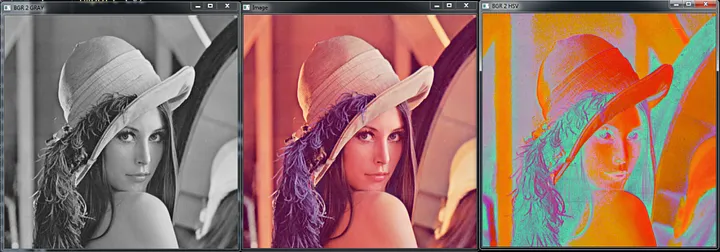
BGR -> IMAGE -> HSV

source : 
- https://kavinithisara.medium.com/image-processing-color-space-conversion-part-2-c093693de58
- https://www.opencv-srf.com/2010/09/object-detection-using-color-seperation.html

OpenCV biasanya menangkap gambar dan video dalam format BGR 8-bit, unsigned integer. Dengan kata lain, gambar yang diambil dapat dianggap sebagai 3 matriks, BIRU, MERAH dan HIJAU dengan nilai integer berkisar antara 0 hingga 255.

Bagaimana gambar BGR terbentuk Pada gambar di atas, setiap kotak kecil mewakili satu piksel gambar. Dalam gambar nyata, piksel-piksel ini sangat kecil sehingga mata manusia tidak dapat membedakannya.

Biasanya, ruang warna BGR dianggap lebih cocok untuk segmentasi berbasis warna. Namun ruang warna HSV adalah ruang warna yang paling cocok untuk segmentasi gambar berbasis warna. Jadi, pada aplikasi di atas, saya telah mengubah ruang warna gambar asli video dari gambar BGR ke gambar HSV.

Ruang warna HSV terdiri dari 3 matriks, 'hue', 'saturation' dan 'value'. Di OpenCV, rentang nilai untuk 'hue', 'saturation' dan 'value' masing-masing adalah 0-179, 0-255, dan 0-255. 'Hue' mewakili warna, 'saturation' mewakili jumlah pencampuran warna tersebut dengan putih, dan 'value' mewakili jumlah pencampuran warna tersebut dengan hitam.

Deteksi kulit manusia menggunakan RGB dan HSV https://openlibrarypublications.telkomuniversity.ac.id/index.php/engineering/article/view/14296/14080

In [11]:
# Create extract color from image function.  
def extract_color_histogram(image, bins=(32,32,32)):
    # Extract 3d color by its hue, saturation, and vue (HSV)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0,1,2], None, bins,
                       [0, 180, 0 , 256, 0, 256])
    
    ### handle normalizing the historigram
    if imutils.is_cv2():
        hist = cv2.normalize(hist)
    else :
        cv2.normalize(hist,hist)
        
    return hist.flatten()

In [27]:
# Initialize the raw pixel intensities matrix
features = []
labels = []

Load image duration 
12.45 - 13.02
(17 minutes)

In [28]:
# Load image data with iteration and color extraction function
for i in range (1,8):
    # Inform iteration data
    print("[INFO] Iteration ", i)
    for classes in subfolders:
        # Inform class label
        print("Processing for label " + classes)

        # Iteration for image data
        for filename in os.scandir(classes):
            if filename.is_file():
                # Get image's path from object filename
                image_path = filename.path
                
                # Read image from image_path 
                image = cv2.imread(image_path)
                
                # Get label from the subfolder name 
                label = classes.split(os.path.sep)[-1]
    
                # Use extract_color_histogram function
                # Features extraction from color histogram image 
                hist = extract_color_histogram(image)
    
                # Add to list
                features.append(hist)
                labels.append(label)
                
    print("[STOP] \n")

[INFO] Iteration  1
Processing for label C:\\Users\SMSK_Narinda\Desktop\Research\dataset\Acne and Rosacea Photos
Processing for label C:\\Users\SMSK_Narinda\Desktop\Research\dataset\Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions
Processing for label C:\\Users\SMSK_Narinda\Desktop\Research\dataset\Atopic Dermatitis Photos
Processing for label C:\\Users\SMSK_Narinda\Desktop\Research\dataset\Bullous Disease Photos
Processing for label C:\\Users\SMSK_Narinda\Desktop\Research\dataset\Cellulitis Impetigo and other Bacterial Infections
Processing for label C:\\Users\SMSK_Narinda\Desktop\Research\dataset\Eczema Photos
Processing for label C:\\Users\SMSK_Narinda\Desktop\Research\dataset\Exanthems and Drug Eruptions
Processing for label C:\\Users\SMSK_Narinda\Desktop\Research\dataset\Hair Loss Photos Alopecia and other Hair Diseases
Processing for label C:\\Users\SMSK_Narinda\Desktop\Research\dataset\Herpes HPV and other STDs Photos
Processing for label C:\\Users\SMSK_Narinda

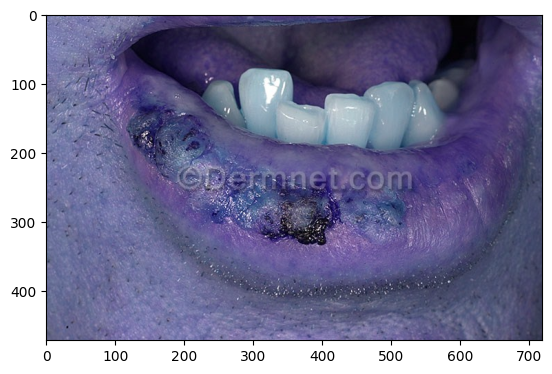

In [29]:
plt.imshow(image)

In [9]:
print("[INFO] Processed {} labels from {} subfolders".format(len(labels), len(subfolders)))

[INFO] Processed 135023 labels from 23 subfolders


In [10]:
# Convert features and labels into array
features = np.array(features)
labels = np.array(labels)

In [11]:
print("[INFO] Features matrix: {:.2f} MB".format(
	features.nbytes / (1024 * 1000.0)))
print("[INFO] Features shape ", features.shape)
print("[INFO] Labels shape ", labels.shape)

[INFO] Features matrix: 17282.94 MB
[INFO] Features shape  (135023, 32768)
[INFO] Labels shape  (135023,)


In [12]:
print(features)
print(labels)

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [0.0000000e+00 3.0938721e-05 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [3.5325098e-03 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.6371789e-03 4.6776542e-05 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]
['Acne and Rosacea Photos' 'Acne and Rosacea Photos'
 'Acne and Rosacea Photos' ...
 'Warts Molluscum and other Viral Infections'
 'Warts Molluscum and other Viral Infections'
 'Warts Molluscum and other Viral Infections']


In [13]:
df = pd.DataFrame(features)
df['Labels'] = labels
df.head

<bound method NDFrame.head of                0         1    2         3    4         5    6    7    8    9  \
0       0.000000  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0   
1       0.000000  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0   
2       0.000000  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0   
3       0.000000  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0   
4       0.403061  0.000126  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0   
...          ...       ...  ...       ...  ...       ...  ...  ...  ...  ...   
135018  0.000000  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0   
135019  0.010924  0.010060  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0   
135020  0.000000  0.000031  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0   
135021  0.003533  0.000000  0.0  0.000000  0.0  0.000000  0.0  0.0  0.0  0.0   
135022  0.001637  0.000047  0.0  0.000047  0.0  0.000047  0.0  0.0  0.0  0.0   

        .

In [14]:
# Split dataset into training and testing set ratio 7 : 3
(trainFeat, testFeat, trainLabels, testLabels) = train_test_split(
	features, labels, test_size=0.3, random_state=42)

# Split dataset into training and validation set ratio 9 : 1
(X_train, x_val, Y_train, y_val) = train_test_split(
	trainFeat, trainLabels, test_size=0.1, random_state=42)

In [15]:
# print('Train data shape: ', x_train.shape)
# print('Train labels shape: ', y_train.shape)
# print('Validation data shape: ', x_val.shape)
# print('Validation labels shape: ', y_val.shape)
# print('Test data shape: ', x_test.shape)
# print('Test labels shape: ', y_test.shape)

print('Train data shape: ', trainFeat.shape)
print('Train labels shape: ', trainLabels.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', testFeat.shape)
print('Test labels shape: ', testLabels.shape)

Train data shape:  (94516, 32768)
Train labels shape:  (94516,)
Validation data shape:  (9452, 32768)
Validation labels shape:  (9452,)
Test data shape:  (40507, 32768)
Test labels shape:  (40507,)


In [16]:
# Set argument for k number of neigbor
ap = argparse.ArgumentParser()
args = ap.parse_args(args=[])
ap.add_argument("-k", "--neighbors", type=int, default=4,
	help="# of nearest neighbors for classification")
args = ap.parse_args(args=[])

## Training Model

In [ ]:
knn = KNeighborsClassifier(n_neighbors=args.neighbors)

In [ ]:
print("[START] KNN Classifier start training the model")

# Define KNN model
model = knn.fit(trainFeat, trainLabels)
%timeit model = knn.fit(trainFeat, trainLabels)

print('[STOP]')

## Evaluating Model; Model Summary

In [20]:
# Model accuracy score
acc = model.score(testFeat, testLabels)

print("[SUMMARY]")
print("KNN classifier : k = %d" % args.neighbors)
print("Model accuracy : {:.2f}%".format(acc * 100))

[SUMMARY]
KNN classifier : k = 4
Model accuracy : 94.98%


In [20]:
# Accuracy score
prediction = knn.predict(testFeat)
acc = accuracy_score(testLabels, prediction)*100
print("Accuracy Score :", acc, "%")

Accuracy Score : 94.98358308440517 %


In [21]:
print("Accuracy score duration :")
%timeit model.score(testFeat, testLabels)

Accuracy score duration :
16min 11s ± 5.17 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
# Cross Validation for model
scores = cross_val_score(
    model, trainFeat, trainLabels, 
    cv=5, scoring='accuracy')

In [45]:
print("[INFO] Cross Validation Model Score : %0.2f (+/- %0.2f)" 
      % (scores.mean()*100, scores.std()*2))
print("[RESULT] Score mean: ", scores.mean()*100, '%')

[INFO] Cross Validation Model Score : 88.14 (+/- 0.01)
[RESULT] Score mean:  88.13639841228765 %


In [42]:
# Additional statistic report of the model
# Source report :
# https://www.datasklr.com/select-classification-methods/k-nearest-neighbors

# Reshape the arrays
testLabels_encoded = testLabels_encoded.reshape(-1, 1)
prediction_encoded = prediction_encoded.reshape(-1, 1)

# Now you can use the reshaped arrays with sklearn metrics functions
print('Average Precision : ', metrics.average_precision_score(testLabels_encoded, prediction_encoded)*100, '%') 
print('F1 Score : ', metrics.f1_score(testLabels_encoded, prediction_encoded, average='weighted')*100, '%')
print('Precision : ', metrics.precision_score(testLabels_encoded, prediction_encoded, average='weighted')*100, '%')
print('Recall : ', metrics.recall_score(testLabels_encoded, prediction_encoded, average='weighted')*100, '%')

Average Precision :  4.481250112756712 %
F1 Score :  95.02382491385806 %
Precision :  95.19046632730641 %
Recall :  94.98358308440517 %


## Classification Report

In [167]:
# Describe unique classes in dataset
classes = []
for unique_class in subfolders:
    # Get label from the subfolder name 
    label = unique_class.split(os.path.sep)[-1]
    classes.append(label)

# Describe classification report
print(classification_report(testLabels, prediction, target_names=classes))

                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos       0.93      0.99      0.96      1830
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.96      0.99      0.97      3029
                                          Atopic Dermatitis Photos       0.94      0.98      0.96      1327
                                            Bullous Disease Photos       0.97      1.00      0.98      1185
                Cellulitis Impetigo and other Bacterial Infections       0.94      0.96      0.95       760
                                                     Eczema Photos       0.95      0.97      0.96      3279
                                      Exanthems and Drug Eruptions       0.97      0.94      0.96      1089
                 Hair Loss Photos Alopecia and other Hair Diseases       0.73      0.91      0.81       630
                           

## Confusion Matrix

Confussion matrix for multiclass explanation

https://www.v7labs.com/blog/confusion-matrix-guide#:~:text=the%20negative%20class.-,Confusion%20Matrix%20for%20Multiple%20Classes,output%20distribution%20by%20the%20classifier.&text=Exemplar%20test%20set%20of%20a%20multi%2Dclass%20dataset.

Confusion matrix, without normalization
[[1815    0    0    0    0    0    1    0    6    0    0    0    0    0
     0    0    0    0    6    0    2    0    0]
 [   0 2997    0    0    0    0    0    6    0    0    6    0    0    0
     0    0    8    0    0    0    0    6    6]
 [   6    5 1300    0    0   10    0    0    0    0    0    0    0    6
     0    0    0    0    0    0    0    0    0]
 [   0    5    0 1180    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [   9    5    0    0  733    0    0    0    0    0    0    0    0    0
     0    0    0    0    7    0    0    0    6]
 [   8    6   36    0    0 3197    0    0    0    0    0    0    4    0
    13    0    0    0    9    0    0    0    6]
 [  28    0    0    0    5    8 1026    0    0    0    0    0    0    0
    22    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0  571    0    0    0    0   59    0
     0    0    0    0    0    0    0    0    0]


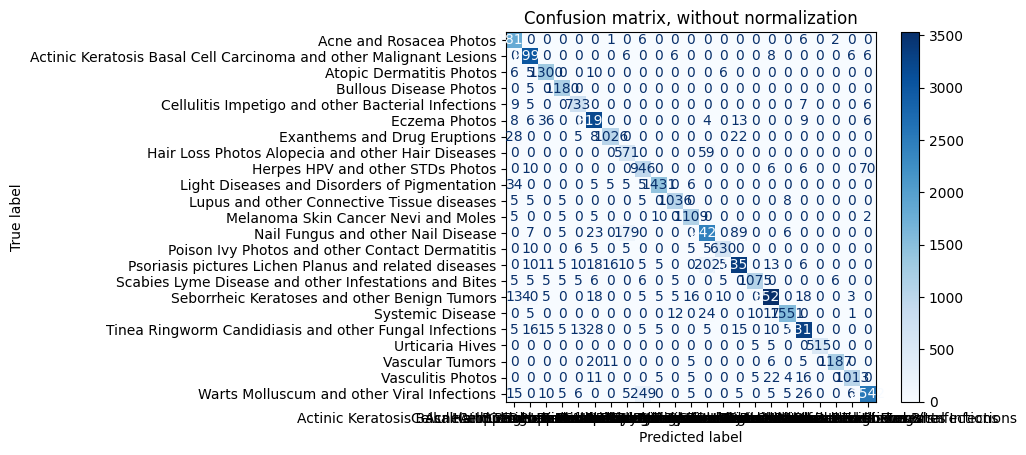

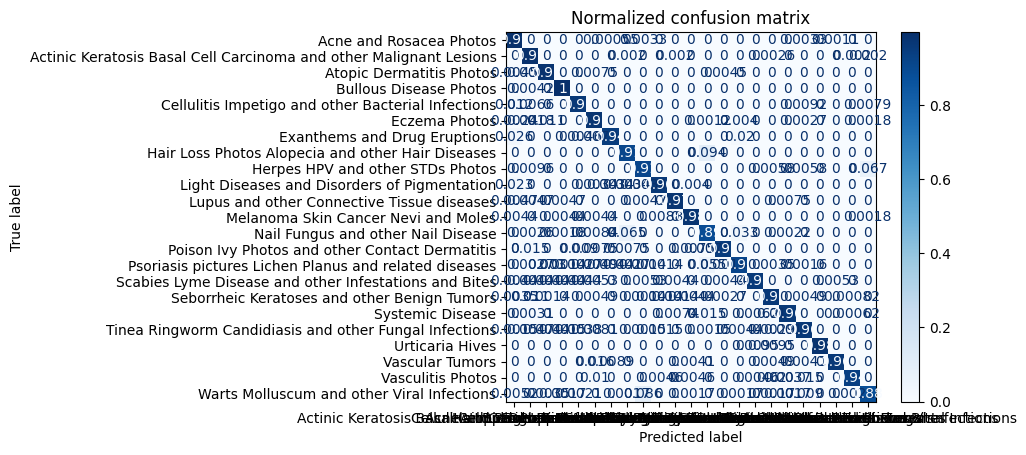

In [152]:
from sklearn.metrics import ConfusionMatrixDisplay

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        testFeat,
        testLabels,
        display_labels=classes,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

<Axes: >

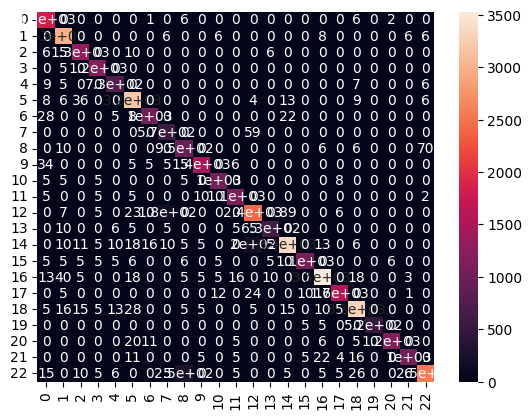

In [157]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [193]:
cm_df = pd.DataFrame(cf_matrix,
                     index =classes, 
                     columns = classes)

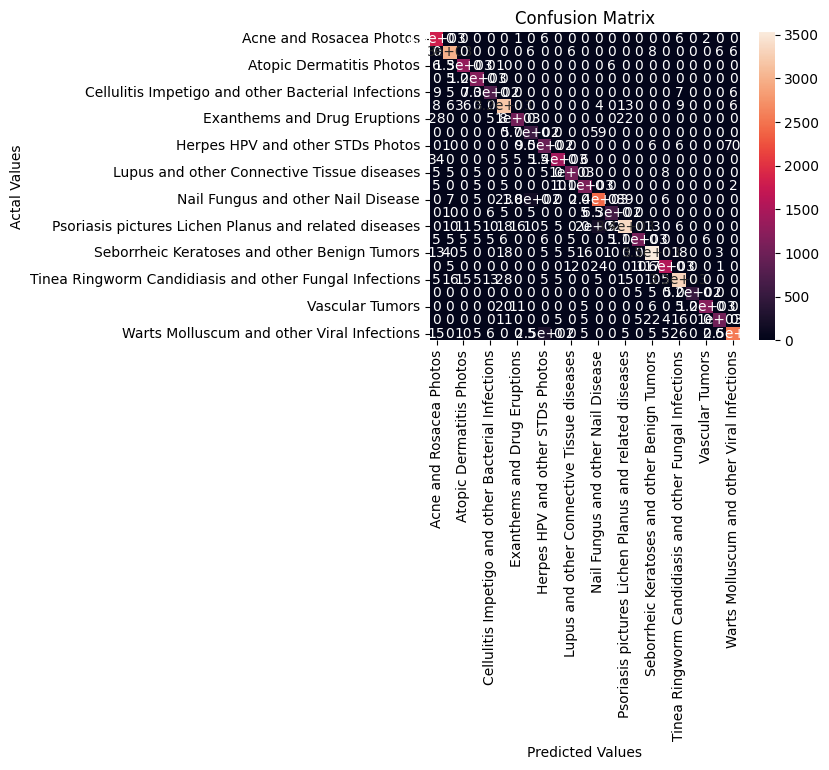

In [194]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [155]:
#Get the confusion matrix
cf_matrix = confusion_matrix(testLabels, prediction)
print(cf_matrix)

[[1815    0    0    0    0    0    1    0    6    0    0    0    0    0
     0    0    0    0    6    0    2    0    0]
 [   0 2997    0    0    0    0    0    6    0    0    6    0    0    0
     0    0    8    0    0    0    0    6    6]
 [   6    5 1300    0    0   10    0    0    0    0    0    0    0    6
     0    0    0    0    0    0    0    0    0]
 [   0    5    0 1180    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [   9    5    0    0  733    0    0    0    0    0    0    0    0    0
     0    0    0    0    7    0    0    0    6]
 [   8    6   36    0    0 3197    0    0    0    0    0    0    4    0
    13    0    0    0    9    0    0    0    6]
 [  28    0    0    0    5    8 1026    0    0    0    0    0    0    0
    22    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0  571    0    0    0    0   59    0
     0    0    0    0    0    0    0    0    0]
 [   0   10    0    0    0    0    0    

In [5]:
import seaborn as sns
from sklearn.model_selection import validation_curve

In [21]:
prediction = model.predict(testFeat)

In [22]:
cf_matrix = confusion_matrix(testLabels, prediction)

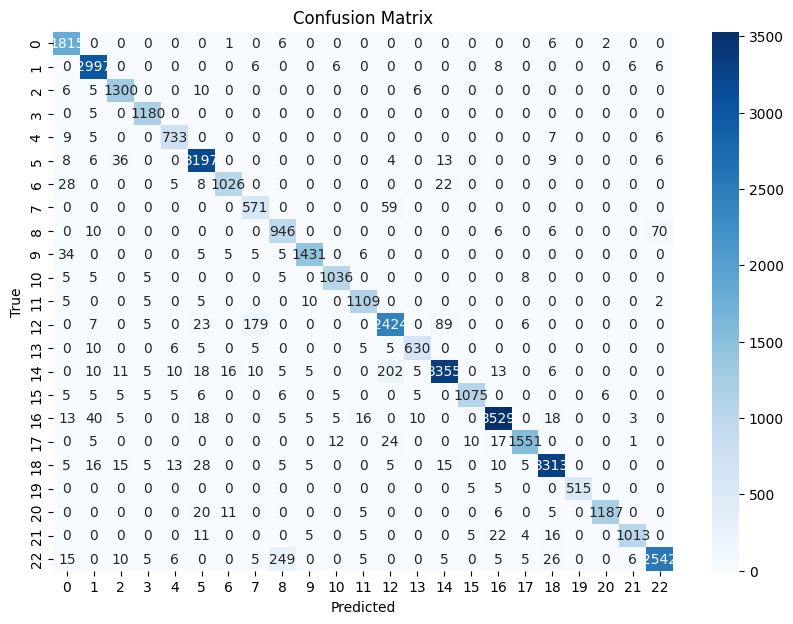

In [23]:
plt.figure(figsize=(10, 7))
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Validation Loss
https://www.google.com/search?q=knn+validation+loss&rlz=1C1ONGR_enID1096ID1096&oq=knn+validation+loss&gs_lcrp=EgZjaHJvbWUyBggAEEUYOTIICAEQABgNGB4yCAgCEAAYDRgeMggIAxAAGA0YHjIKCAQQABiABBiiBDIKCAUQABiABBiiBDIKCAYQABiABBiiBDIKCAcQABiABBiiBNIBCDMyNTVqMGo0qAIAsAIB&sourceid=chrome&ie=UTF-8
https://www.geeksforgeeks.org/validation-curve/

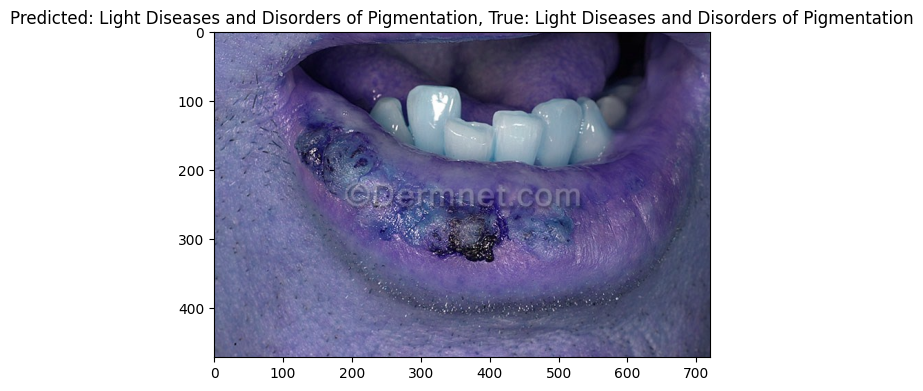

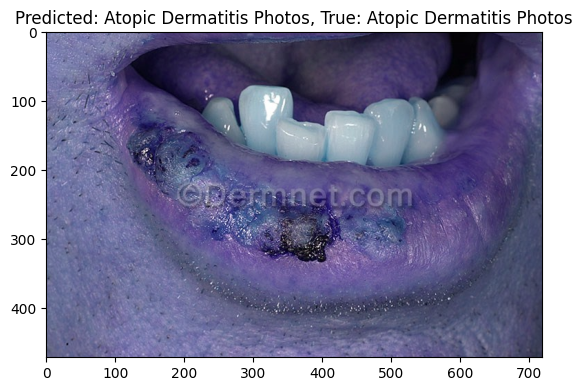

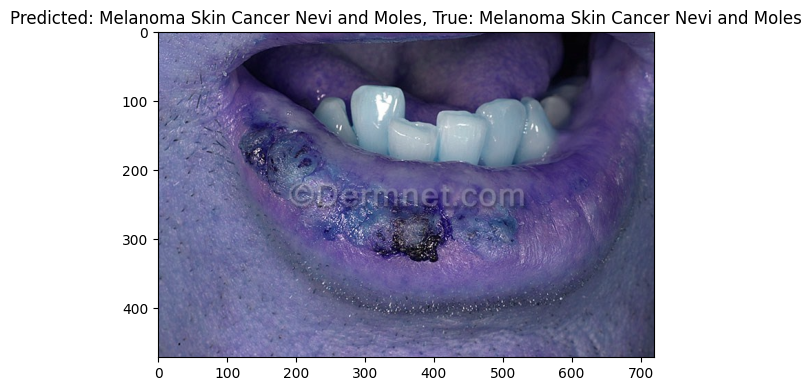

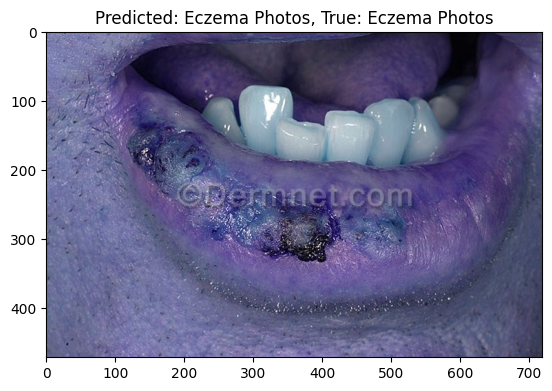

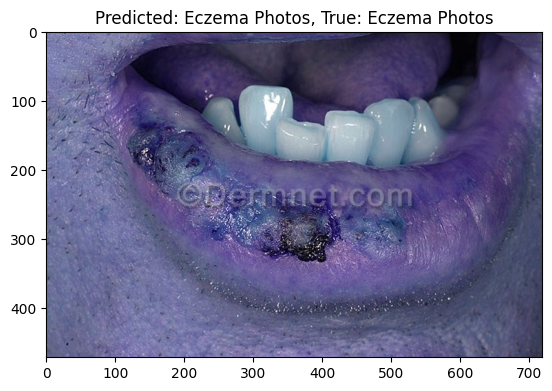

In [27]:
n_samples = 5
indices = np.random.choice(len(testFeat), n_samples, replace=False)
for index in indices:
    plt.imshow(image, cmap='gray')
    plt.title(f'Predicted: {prediction[index]}, True: {testLabels[index]}')
    plt.show()

In [33]:
# print('Train data shape: ', x_train.shape)
# print('Train labels shape: ', y_train.shape)
# print('Validation data shape: ', x_val.shape)
# print('Validation labels shape: ', y_val.shape)
# print('Test data shape: ', x_test.shape)
# print('Test labels shape: ', y_test.shape)

print('Train data shape: ', trainFeat.shape)
print('Train labels shape: ', trainLabels.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', testFeat.shape)
print('Test labels shape: ', testLabels.shape)
print('Test prediction shape: ', prediction.shape)

Train data shape:  (94516, 32768)
Train labels shape:  (94516,)
Validation data shape:  (9452, 32768)
Validation labels shape:  (9452,)
Test data shape:  (40507, 32768)
Test labels shape:  (40507,)
Test prediction shape:  (40507,)


## Save Model

In [46]:
pickle.dump(model,open('KNNClassifier.p','wb'))
print("[INFO] Model is saved successfully")

[INFO] Model is saved successfully


## Testing Model

In [4]:
# Load model
model = pickle.load(open('KNNClassifier.p','rb'))
print("[INFO] Model loaded successfully")

[INFO] Model loaded successfully


Source contoh gambar : "C:\Users\SMSK_Narinda\Downloads\089056200_1612266979-Melanoma.jpg"
https://www.klikdokter.com/info-sehat/kanker/perbedaan-kanker-kulit-melanoma-dan-karsinoma


In [8]:
# Input example image
path = input('Enter URL of Image')

# Mendapatkan label dari nama subfolder
img_name = path.split(os.path.sep)[-1]
print(img_name)

Enter URL of Image C:\Users\SMSK_Narinda\Downloads\089056200_1612266979-Melanoma.jpg


089056200_1612266979-Melanoma.jpg


In [21]:
# Fungsi untuk menguji gambar dan mendapatkan prediksi
def test_image(model, image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    test_image = extract_color_histogram(img)
    test_feature = np.array(test_image).reshape(1, -1)
    predicted_class = model.predict(test_feature)[0]
    return predicted_class

In [23]:
# Menguji gambar dan mendapatkan prediksi
predicted_class = test_image(model, path)

# print(predicted_class)

In [18]:
true_labels = []

for label in os.listdir(data_path):
    true_labels.append(label)

In [16]:
# Membuat dropdown widget
true_label_dropdown = widgets.Dropdown(
    options=true_labels,
    description='True Label:',
    disabled=False,
)

# Menampilkan dropdown
display(true_label_dropdown)

Dropdown(description='True Label:', options=(), value=None)

In [239]:
# Mendapatkan nilai dari dropdown
true_label = true_label_dropdown.value

print("Selected True Label:", true_label)

Selected True Label: Nail Fungus and other Nail Disease


In [24]:
# Menampilkan hasil prediksi
print(f"Image: {os.path.basename(path)}")
# print(f"True Label: {true_label}")
print(f"Predicted Class: {predicted_class}")

Image: 089056200_1612266979-Melanoma.jpg
Predicted Class: Melanoma Skin Cancer Nevi and Moles


In [241]:
# Menghitung dan menampilkan akurasi untuk gambar ini
accuracy = accuracy_score([true_label], [predicted_class])
print(f"Accuracy for this image: {accuracy * 100:.2f}%")

Accuracy for this image: 0.00%


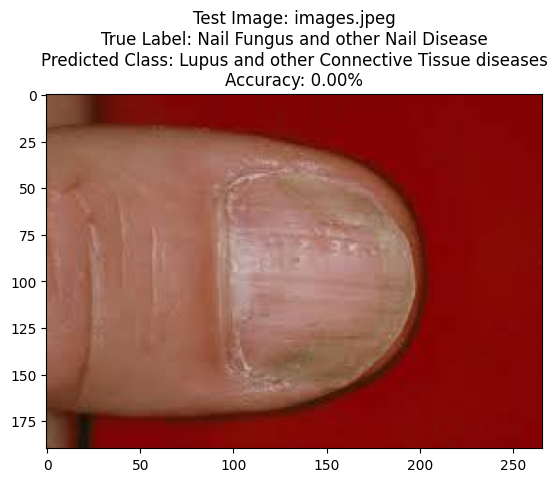

In [242]:
# Menampilkan gambar
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title(f"Test Image: {os.path.basename(path)}\nTrue Label: {true_label}\nPredicted Class: {predicted_class}\nAccuracy: {accuracy * 100:.2f}%")
plt.show()

### DUMPED

#### Testing

In [41]:
probability = model.predict_proba(test_image.reshape(1, -1))

In [42]:
model.predict(test_image.reshape(1, -1))

array(['Melanoma Skin Cancer Nevi and Moles'], dtype='<U66')

In [44]:
print("Predicted Class:", model.predict(test_image.reshape(1, -1)))
print("Probabilities:", probability)

Predicted Class: ['Melanoma Skin Cancer Nevi and Moles']
Probabilities: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [154]:
print("Image size is ", img.size)
print("Image shape is ", img.shape)

Image size is  801090
Image shape is  (387, 690, 3)


In [155]:
test_image = extract_color_histogram(img)

In [37]:
test_feature = np.array(test_image)

In [38]:
test_feature = np.array(test_image)
print("[INFO] Test Image Feature matrix: {:.2f} MB".format(
	test_feature.nbytes / (1024 * 1000.0)))
print("[INFO] Test Image Feature shape ", test_feature.shape)

[INFO] Test Image Feature matrix: 0.13 MB
[INFO] Test Image Feature shape  (32768,)


In [168]:
# Mengambil elemen pertama dari tuple sebagai string
predicted_class = predicted_class[0]

print(predicted_class)  # Output: 'Vasculitis Photos'

M


In [ ]:
# if probability.ndim == 1:
#     probability = probability.reshape(1, -1)  # Reshape to make it 2D

# # Iterate over the rows of the probability array
# for ind, val in enumerate(labels):
#     print(f'{val} = {probability[0][ind]*100}%')

# print("The predicted image is : "+Categories[model.predict(l)[0]])
# print(f'Is the image a {Categories[model.predict(l)[0]]} ?(y/n)')
# while True:
#     b=input()
#     if(b=="y" or b=="n"):
#         break
#     print("please enter either y or n")

In [ ]:
# img_resize=resize(img,(150,150,3))
# l=[img_resize.flatten()]
# probability = model.predict_proba(l)


# for ind,val in enumerate(Categories):
#   print(f'{val} = {probability[0][ind]*100}%')
# print("The predicted image is : "+Categories[model.predict(l)[0]])
# print(f'Is the image a {Categories[model.predict(l)[0]]} ?(y/n)')
# while(True:
#   b=input()
#   if(b=="y" or b=="n"):
#     break
#   print("please enter either y or n")

# if(b=='n'):
#   print("What is the image?")
#   for i in range(len(Categories)):
#     print(f"Enter {i} for {Categories[i]}")
#   k=int(input())
#   while(k<0 or k>=len(Categories)):
#     print(f"Please enter a valid number between 0-{len(Categories)-1}")
#     k=int(input())
#   print("Please wait for a while for the model to learn from this image :)")
#   flat_arr=flat_data_arr.copy()
#   tar_arr=target_arr.copy()
#   tar_arr.append(k)
#   flat_arr.extend(l)
#   tar_arr=np.array(tar_arr)
#   flat_df=np.array(flat_arr)
#   df1=pd.DataFrame(flat_df)
#   df1['Target']=tar_arr
#   model1=GridSearchCV(svc,param_grid)
#   x1=df1.iloc[:,:-1]
#   y1=df1.iloc[:,-1]
#   x_train1,x_test1,y_train1,y_test1=train_test_split(x1,y1,test_size=0.20,random_state=77,stratify=y1)
#   d={}
#   for i in model.best_params_:
#     d[i]=[model.best_params_[i]]
#   model1=GridSearchCV(svc,d)
#   model1.fit(x_train1,y_train1)
#   y_pred1=model.predict(x_test1)
#   print(f"The model is now {accuracy_score(y_pred1,y_test1)*100}% accurate")
#   pickle.dump(model1,open('img_model.p','wb'))
# print("Thank you for your feedback")